### To do list
todo:
- make debug function that logs errors
- make mel matrix 
- make spec col

In [1]:
# to ensure that the modules can be imported, as they are located in a different folder, add the package root to the path:

import sys
sys.path.insert(0, "../")


### Set working directory

In [2]:
# Import the os module
import os

# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

# Change the current working directory
datadir = ('/vol/tensusers2/aliesenfeld/Elpaco dataset/')
#packagedir = ('vol/)
#os.chdir('/Users/u517177/continuer_paper/')


# Print the current working directory
#print("Current working directory: {0}".format(os.getcwd()))

Current working directory: /home/bvreede


# Part 1: audio extraction

### Dependencies


In [3]:
#on M1 mac librosa needs to be installed via miniforge
#!conda install -c conda-forge librosa
import subprocess
import json
import sounddevice as sd

import wave
import IPython
import librosa
import pandas as pd
from scipy.io import wavfile
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 10

/tmp/ipykernel_509310/67386651.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [8]:
#install tensorflow if needed

#!conda install -c conda-forge tensorflow -y
#!pip install tensorflow-macos

'Elpaco dataset'/              output/         streaks_10perlang.csv
'continuer data'/              output_trail/   streaks_1perlang.csv
 continuers_for_audio.csv      streaks/        streaks_50perlang.csv
 discontinuers_for_audio.csv   streaks.csv     zic1z6cK


### Inspect single audio files

In [4]:
#Load and inspect single files
audiofile = wave.open('./Elpaco dataset/akhoe_haikom1/state_hospital.wav','r')

print( "Number of channels",audiofile.getnchannels())
print ( "Sample width",audiofile.getsampwidth())
print ( "Frame rate.",audiofile.getframerate())
print ("Number of frames",audiofile.getnframes())
print ( "parameters:",audiofile.getparams())

FileNotFoundError: [Errno 2] No such file or directory: './Elpaco dataset/akhoe_haikom1/state_hospital.wav'

In [4]:
#play audio files
#IPython.display.Audio('./Elpaco dataset/akhoe_haikom1/state_hospital.wav')



### read csv

In [5]:
#read csv 
datasource = datadir + 'continuers_for_audio.csv'

df_audio = pd.read_csv(datasource)
#Optional:
#check timestamp format and .div is needed to match audio extaction function requirements
df_audio['begin'] = df_audio['begin'].div(1000)
df_audio['end'] = df_audio['end'].div(1000)

#drop czech because it has separate speaker channels
df_audio = df_audio[df_audio.language != "czech"]

#exclude corpora without audio files
df_audio = df_audio[df_audio.language != "italian"]
df_audio = df_audio[df_audio.language != "zacatepec_chatino"]

#drop files without audio

df_audio.dropna(subset=['begin','end'], inplace=True)
df_audio = df_audio.groupby(['source']).apply(lambda x: x.sample(1, replace=True)).reset_index(drop=True)

df_audio_sub = df_audio[:10]
df_audio_sub

,uid,language,begin,end,duration,source,participant,utterance_stripped,utterance,form_ascii
0,akhoe_haikom-2-484-1291852,akhoe_haikom,1291.852,1292.192,340.0,/akhoe_haikom1/state_hospital,tx@Ga,î,î,i_
1,akie-1-212-449198,akie,449.198,449.791,593.0,/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo,B,aá,aá,aa_
2,ambel-3-509-809080,ambel,809.080,810.020,940.0,/ambel1/AM064,ESD_Transcription-txt-wgo,oo,oo,oo
3,ambel-4-125-205440,ambel,205.440,206.100,660.0,/ambel1/AM067,WG_Transcription-txt-wgo,mm,mm,mm
4,anal-01-283-507370,anal,507.370,507.890,520.0,/anal1/anm_20160916_PO_Wolring_1,Anal sp2,mm,mm,mm
5,anal-05-029-60356,anal,60.356,61.126,770.0,/anal1/anm_20160924_Thotson_grandmothers_1,Anal sp2,ing,ing,ing
6,anal-08-437-607867,anal,607.867,608.365,498.0,/anal1/anm_20161014_PO_Darchol_evening_convers...,anal speaker 4,umm,umm,umm
7,anal-09-264-932963,anal,932.963,934.383,1420.0,/anal1/anm_20161014_PO_Ralruwng_family_lunch1,Anal sp1,umm,umm,umm
8,anal-12-577-1069261,anal,1069.261,1070.298,1037.0,/anal1/anm_20161210_oklu_chatting3,Anal sp 5,umm,umm,umm
9,anal-13-047-69501,anal,69.501,70.127,626.0,/anal1/anm_20190803_grandmas,anal speaker 1,amato,amato,amato


### `read_audio` function

In [6]:
from sktalk import read_audio

# def get_sampling_rate(file_path):
#     cmd = [
#         "ffprobe",
#         "-v", "quiet",
#         "-print_format", "json",
#         "-show_streams",
#         file_path
#     ]

#     result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
#     output = json.loads(result.stdout)

#     for stream in output["streams"]:
#         if stream["codec_type"] == "audio":
#             return int(stream["sample_rate"])

#     raise ValueError("No audio stream found in the file")

# # Replace 'list_audio_3_40_balanced.wav' with the path to your audio file
# # file_path = './Elpaco dataset/akhoe_haikom1/state_hospital.wav'

# # sampling_rate = get_sampling_rate(file_path)
# # print(sampling_rate)


# def get_audio_ffmpeg(file_path):
#     cmd = ["ffmpeg", "-i", file_path, '-f', 's16le',
#            '-acodec', 'pcm_s16le',
#            '-ar', '22050',
#            '-ac', '1',
#            '-']

#     pipe = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#     raw_audio = pipe.stdout
#     audio_array = np.frombuffer(raw_audio, dtype="int16")
#     audio_array = audio_array.astype(np.float32) / np.iinfo(np.int16).max

#     return audio_array


wavaddress = "/vol/tensusers2/aliesenfeld/Elpaco dataset/Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav"
d_ffmpeg = read_audio.get_audio_ffmpeg(wavaddress)
r_ffmpeg = read_audio.get_sampling_rate(wavaddress)

#ffmpeg -ss start_second -to end_second -i input.mp3 output.mp3

d_librosa, r_librosa = librosa.load(wavaddress)


ModuleNotFoundError: No module named 'sktalk'

In [5]:
print(d_ffmpeg[:10])
print(d_librosa[:10])

print(len(d_ffmpeg))
print(len(d_librosa))

print(max(d_ffmpeg))
print(max(d_librosa))

print(min(d_ffmpeg))
print(min(d_librosa))


print(r_ffmpeg)
print(r_librosa)


[ 0.0000000e+00 -3.0518509e-05 -3.0518509e-05 -3.0518509e-05
 -6.1037019e-05 -9.1555528e-05 -1.2207404e-04 -1.5259255e-04
 -2.1362957e-04 -2.4414808e-04]
[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 -4.6558678e-05
 -5.6192279e-05 -8.2075596e-05 -1.2717396e-04 -1.5640259e-04
 -2.0396709e-04 -2.4517626e-04]
24007680
24007680
1.0
1.2539232
-1.0000305
-1.0577291
44100
22050


In [6]:
import pickle

with open("../barbara_test/d_librosa.pickle", "wb") as f:
    pickle.dump(d_librosa, f)

with open("../barbara_test/r_librosa.pickle", "wb") as f:
    pickle.dump(r_librosa, f)

with open("../barbara_test/d_ffmpeg.pickle", "wb") as f:
    pickle.dump(d_ffmpeg, f)

with open("../barbara_test/r_ffmpeg.pickle", "wb") as f:
    pickle.dump(r_ffmpeg, f)



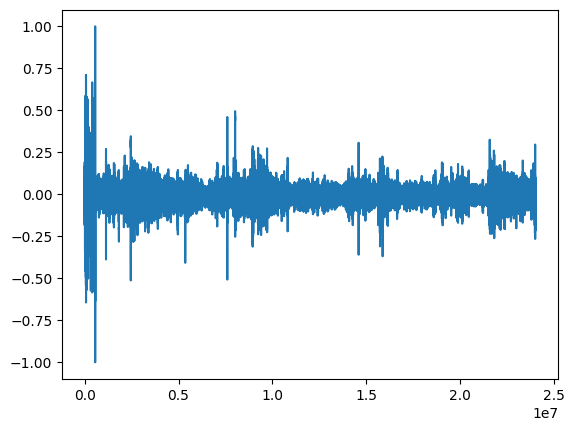

In [7]:
import matplotlib.pyplot as plt

plt.plot(d_ffmpeg)

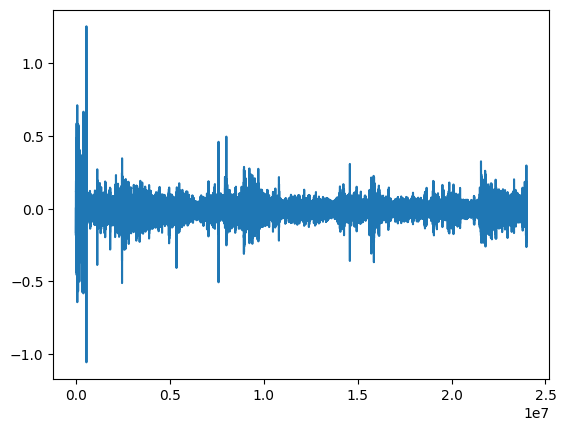

In [8]:
plt.plot(d_librosa)

In [16]:
import soundfile as sf
import numpy as np
import simpleaudio as sa

# Generate a sine wave
freq = 440
duration = 3
sample_rate = 44100
t = np.linspace(0, duration, int(duration * sample_rate), False)
waveform = np.sin(freq * t * 2 * np.pi) * 32767

# Play the audio
audio_data = waveform.astype(np.int16)
play_obj = sa.play_buffer(audio_data, 1, 2, sample_rate)

# Wait for the audio to finish playing
play_obj.wait_done()

In [ ]:
import soundfile as sf
import numpy as np
import simpleaudio as sa

# Read the WAV file
filename = "./Elpaco dataset/akhoe_haikom1/state_hospital.wav"
audio_data, sample_rate = sf.read(filename)

# Convert the audio data to the correct format
audio_data = (audio_data * 32767).astype(np.int16)

# Play the audio
play_obj = sa.play_buffer(audio_data, 2, 2, sample_rate)

# Wait for the audio to finish playing
play_obj.wait_done()


In [33]:
n = 1

audiorow_start = df_audio["begin"][n]
audiorow_end = df_audio["end"][n]
audiorow_file = df_audio["source"][n]

print(audiorow_file, audiorow_start, audiorow_end)2

#get_audio_ffmpeg(audiorow_file, audiorow_start, audiorow_end)

ffmpeg -ss 112.708 -to 113.647 -i
/vol/tensusers2/aliesenfeld/Elpaco\ dataset/Elpaco\ dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav

/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo 112.708 113.647


In [22]:

def get_row_audio(df):
    """ load audio and grab individual turns
    TODO: for large sparse WAV files, the audio should be loaded only for the turn
    """
    print(df["source"])
    #source = df["source"][0]
    #wav_loc = f'./Elpaco dataset{source}.wav'
    #print path to audio file (optional)
    #print(wav_loc)

    # # load audio
    # try:
    #     #Three options here, comment out as needed:

    #     #scipy wavfile
    #     #rate, data = wavfile.read(wav_loc)
        
    #     #librosa
    #     rate, data = librosa.load(wav_loc)
        
    #     #base python
    #     #rate, data = wave.open(wav_loc)

    #     #explore fourth option: use ffmpeg directly 
    #     #ffmpeg?

    #     data = data.astype('float32')
        
    #     # get audio for each turn
    #     df_audio["audio"] = [
    #         data[int(st * rate) : int(et * rate)].copy(deep=True)
    #         for st, et in zip(df_audio.begin.values, df_audio.end.values)
    #     ]

    #     df_audio["rate"] = rate
    # except Exception:
    #     pass

    # return df_audio

[get_row_audio(df_audio[df_audio.source == source]) for source in df_audio.source[1:10]]



1    /akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo
Name: source, dtype: object
2    /ambel1/AM064
Name: source, dtype: object
3    /ambel1/AM067
Name: source, dtype: object
4    /anal1/anm_20160916_PO_Wolring_1
Name: source, dtype: object
5    /anal1/anm_20160924_Thotson_grandmothers_1
Name: source, dtype: object
6    /anal1/anm_20161014_PO_Darchol_evening_convers...
Name: source, dtype: object
7    /anal1/anm_20161014_PO_Ralruwng_family_lunch1
Name: source, dtype: object
8    /anal1/anm_20161210_oklu_chatting3
Name: source, dtype: object
9    /anal1/anm_20190803_grandmas
Name: source, dtype: object


[None, None, None, None, None, None, None, None, None]

In [35]:
def get_row_audio(df, wav_loc):
    """ load audio and grab individual turns
    TODO: for large sparse WAV files, the audio should be loaded only for the turn
    """
    
    #print path to audio file (optional)
    print(wav_loc)

    # load audio

        #Three options here, comment out as needed:

    #scipy wavfile
    #rate, data = wavfile.read(wav_loc)
    
    #librosa
    data, rate = librosa.load(wav_loc)
    
    #base python
    #rate, data = wave.open(wav_loc)

    #explore fourth option: use ffmpeg directly 
    #ffmpeg?

    data = data.astype('float32')
    
    # get audio for each turn
    # df_audio["audio"] = [
    #     data[int(st * rate) : int(et * rate)].copy()
    #     for st, et in zip(df_audio.begin.values, df_audio.end.values)
    # ]

    df["rate"] = rate

    return df

sounddata = [get_row_audio(df_audio[df_audio.source == source], f'./Elpaco dataset{source}.wav') for source in df_audio.source[:10]]

./Elpaco dataset/akhoe_haikom1/state_hospital.wav


/tmp/ipykernel_2478552/3405997377.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rate"] = rate


./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2478552/3405997377.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rate"] = rate


./Elpaco dataset/ambel1/AM064.wav


/tmp/ipykernel_2478552/3405997377.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rate"] = rate


./Elpaco dataset/ambel1/AM067.wav


/tmp/ipykernel_2478552/3405997377.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rate"] = rate


./Elpaco dataset/anal1/anm_20160916_PO_Wolring_1.wav


/tmp/ipykernel_2478552/3405997377.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rate"] = rate


./Elpaco dataset/anal1/anm_20160924_Thotson_grandmothers_1.wav


/tmp/ipykernel_2478552/3405997377.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rate"] = rate


./Elpaco dataset/anal1/anm_20161014_PO_Darchol_evening_conversation2.wav


/tmp/ipykernel_2478552/3405997377.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rate"] = rate


./Elpaco dataset/anal1/anm_20161014_PO_Ralruwng_family_lunch1.wav


/tmp/ipykernel_2478552/3405997377.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rate"] = rate


./Elpaco dataset/anal1/anm_20161210_oklu_chatting3.wav


/tmp/ipykernel_2478552/3405997377.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rate"] = rate


./Elpaco dataset/anal1/anm_20190803_grandmas.wav


/tmp/ipykernel_2478552/3405997377.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rate"] = rate


In [26]:
len(sounddata)

33626250

In [14]:
df_audio_sub.iloc[:,3]

0    1313.280
1     441.654
2     327.840
3     391.990
4     527.017
5      63.633
6     152.779
7    1278.735
8    1070.298
9     659.145
Name: end, dtype: float64

### Loops for execution

In [6]:
#execute as for loop
#[get_row_audio(df_audio[df_audio.source == source], './Elpaco dataset'+ source +'.wav') for source in df_audio.source]
#[get_sampling_rate(f'./Elpaco dataset{source}.wav') for source in df_audio.source[1:10]]

df_audio_10 = [get_row_audio(df_audio[df_audio.source == source], f'./Elpaco dataset{source}.wav') for source in df_audio.source[1:10]]
#[get_sampling_rate('./Elpaco dataset'+ source +'.wav') for source in df_audio.source]

print(df_audio_10)


./Elpaco dataset/akhoe_haikom1/state_hospital.wav
[-0.0135576   0.00900845 -0.00217441 ... -0.00039207 -0.00038838
 -0.00041938]
./Elpaco dataset/akhoe_haikom1/state_hospital.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate


[-0.0135576   0.00900845 -0.00217441 ... -0.00039207 -0.00038838
 -0.00041938]
./Elpaco dataset/akhoe_haikom1/state_hospital.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate


[-0.0135576   0.00900845 -0.00217441 ... -0.00039207 -0.00038838
 -0.00041938]
./Elpaco dataset/akhoe_haikom1/state_hospital.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate


[-0.0135576   0.00900845 -0.00217441 ... -0.00039207 -0.00038838
 -0.00041938]
./Elpaco dataset/akhoe_haikom1/state_hospital.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate


[-0.0135576   0.00900845 -0.00217441 ... -0.00039207 -0.00038838
 -0.00041938]
./Elpaco dataset/akhoe_haikom1/state_hospital.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate


[-0.0135576   0.00900845 -0.00217441 ... -0.00039207 -0.00038838
 -0.00041938]
./Elpaco dataset/akhoe_haikom1/state_hospital.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate


[-0.0135576   0.00900845 -0.00217441 ... -0.00039207 -0.00038838
 -0.00041938]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate


[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate


[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
[                          uid      language      begin        end  duration   
0   akhoe_haikom-2-194-371425  akhoe_haikom   371425.0   371725.0     300.0  \
1   akhoe_haikom-2-203-398335  akhoe_haikom   398335.0   398545.0     210.0   
2  akhoe_haikom-2-457-1245412  akhoe_haikom  1245412.0  1245780.0     368.0   
3  akhoe_haikom-2-459-1247720  akhoe_haikom  1247720.0  1248010.0     290.0   
4  akhoe_haikom-2-482-1290491  akhoe_haikom  1290491.0  1290851.0     360.0   
5  akhoe_haikom-2-484-1291852  akhoe_haikom  1291852.0  1292192.0     340.0   
6  akhoe_haikom-2-492-1300050  akhoe_haikom  1300050.0  1300810.0     760.0   
7  akhoe_haikom-2-494-1312920  akhoe_haikom  1312920.0  1313280.0     360.0   

                          source participant utterance_stripped utterance   
0  /akhoe_haikom1/state_hospital       tx@Es                  î         î  \
1  /akhoe_haikom1/state_hospital    

/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate


In [24]:
print(df_audio_10["rate"])

TypeError: list indices must be integers or slices, not str

In [7]:
#execute using parallel 

with Parallel(n_jobs=1, verbose=verbosity) as parallel:
    df_audios = parallel(
        delayed(get_row_audio)(
            df_audio[df_audio.source == source], 
            './Elpaco dataset'+ source +'.wav', #Edit path to corpus directory here
        )
        for source in tqdm(df_audio.source)
    )
df_audio = pd.concat(df_audios)
len(df_audio)

  0%|                                                                                                                                       | 0/139551 [00:00<?, ?it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


./Elpaco dataset/akhoe_haikom1/state_hospital.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
  0%|                                                                                                                            | 1/139551 [00:02<80:08:57,  2.07s/it]

[-0.0135576   0.00900845 -0.00217441 ... -0.00039207 -0.00038838
 -0.00041938]
./Elpaco dataset/akhoe_haikom1/state_hospital.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s
  0%|                                                                                                                            | 2/139551 [00:04<80:08:32,  2.07s/it]

[-0.0135576   0.00900845 -0.00217441 ... -0.00039207 -0.00038838
 -0.00041938]
./Elpaco dataset/akhoe_haikom1/state_hospital.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.2s remaining:    0.0s
  0%|                                                                                                                            | 3/139551 [00:06<80:07:38,  2.07s/it]

[-0.0135576   0.00900845 -0.00217441 ... -0.00039207 -0.00038838
 -0.00041938]
./Elpaco dataset/akhoe_haikom1/state_hospital.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.3s remaining:    0.0s
  0%|                                                                                                                            | 4/139551 [00:08<80:02:24,  2.06s/it]

[-0.0135576   0.00900845 -0.00217441 ... -0.00039207 -0.00038838
 -0.00041938]
./Elpaco dataset/akhoe_haikom1/state_hospital.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   10.3s remaining:    0.0s
  0%|                                                                                                                            | 5/139551 [00:10<80:02:09,  2.06s/it]

[-0.0135576   0.00900845 -0.00217441 ... -0.00039207 -0.00038838
 -0.00041938]
./Elpaco dataset/akhoe_haikom1/state_hospital.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   12.4s remaining:    0.0s
  0%|                                                                                                                            | 6/139551 [00:12<80:01:14,  2.06s/it]

[-0.0135576   0.00900845 -0.00217441 ... -0.00039207 -0.00038838
 -0.00041938]
./Elpaco dataset/akhoe_haikom1/state_hospital.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   14.5s remaining:    0.0s
  0%|                                                                                                                            | 7/139551 [00:14<80:04:24,  2.07s/it]

[-0.0135576   0.00900845 -0.00217441 ... -0.00039207 -0.00038838
 -0.00041938]
./Elpaco dataset/akhoe_haikom1/state_hospital.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   16.5s remaining:    0.0s
  0%|                                                                                                                            | 8/139551 [00:16<80:12:56,  2.07s/it]

[-0.0135576   0.00900845 -0.00217441 ... -0.00039207 -0.00038838
 -0.00041938]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   16.9s remaining:    0.0s
  0%|                                                                                                                            | 9/139551 [00:16<59:12:18,  1.53s/it]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 10/139551 [00:17<44:55:27,  1.16s/it]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 11/139551 [00:17<35:09:20,  1.10it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 12/139551 [00:17<28:24:14,  1.36it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 13/139551 [00:18<23:44:21,  1.63it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 14/139551 [00:18<20:29:54,  1.89it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 15/139551 [00:18<18:14:55,  2.12it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 16/139551 [00:19<16:39:23,  2.33it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 17/139551 [00:19<15:32:29,  2.49it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 18/139551 [00:19<14:47:29,  2.62it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 19/139551 [00:20<14:16:08,  2.72it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 20/139551 [00:20<13:54:20,  2.79it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 21/139551 [00:20<13:38:43,  2.84it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 22/139551 [00:21<13:27:11,  2.88it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 23/139551 [00:21<13:18:54,  2.91it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 24/139551 [00:21<13:12:15,  2.94it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 25/139551 [00:22<13:08:02,  2.95it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 26/139551 [00:22<13:04:45,  2.96it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 27/139551 [00:22<13:03:20,  2.97it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 28/139551 [00:23<13:02:30,  2.97it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 29/139551 [00:23<13:01:43,  2.97it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 30/139551 [00:23<13:01:18,  2.98it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 31/139551 [00:24<13:00:16,  2.98it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 32/139551 [00:24<13:00:37,  2.98it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 33/139551 [00:24<13:00:54,  2.98it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 34/139551 [00:25<12:59:45,  2.98it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 35/139551 [00:25<13:00:39,  2.98it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 36/139551 [00:25<12:59:51,  2.98it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/akie1/2014-01-20Gitu4ConversationBahatiNkoiseyyo.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 37/139551 [00:26<13:00:26,  2.98it/s]

[ 3.2782555e-07 -4.1872263e-05 -2.2262335e-05 ... -4.3265522e-05
 -1.9449741e-05 -5.1818788e-05]
./Elpaco dataset/ambel1/AM064.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 38/139551 [00:27<26:15:27,  1.48it/s]

[0.01039876 0.01774596 0.01658991 ... 0.00565859 0.010403   0.        ]
./Elpaco dataset/ambel1/AM064.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 39/139551 [00:29<35:32:26,  1.09it/s]

[0.01039876 0.01774596 0.01658991 ... 0.00565859 0.010403   0.        ]
./Elpaco dataset/ambel1/AM064.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 40/139551 [00:30<42:03:01,  1.09s/it]

[0.01039876 0.01774596 0.01658991 ... 0.00565859 0.010403   0.        ]
./Elpaco dataset/ambel1/AM064.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 41/139551 [00:32<46:33:55,  1.20s/it]

[0.01039876 0.01774596 0.01658991 ... 0.00565859 0.010403   0.        ]
./Elpaco dataset/ambel1/AM064.wav


/tmp/ipykernel_2450982/2935496521.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_audio["rate"] = rate
  0%|                                                                                                                           | 42/139551 [00:33<49:44:18,  1.28s/it]

[0.01039876 0.01774596 0.01658991 ... 0.00565859 0.010403   0.        ]
./Elpaco dataset/ambel1/AM064.wav


KeyboardInterrupt: 

### Normalize audio  (optional)

In [9]:
# normalize audio if needed
df_audio['audio'] = [librosa.util.normalize(i) for i in df_audio.audio.values]

### Plot `audio` column waveforms

  5%|▍         | 11/240 [00:00<00:00, 254.29it/s]


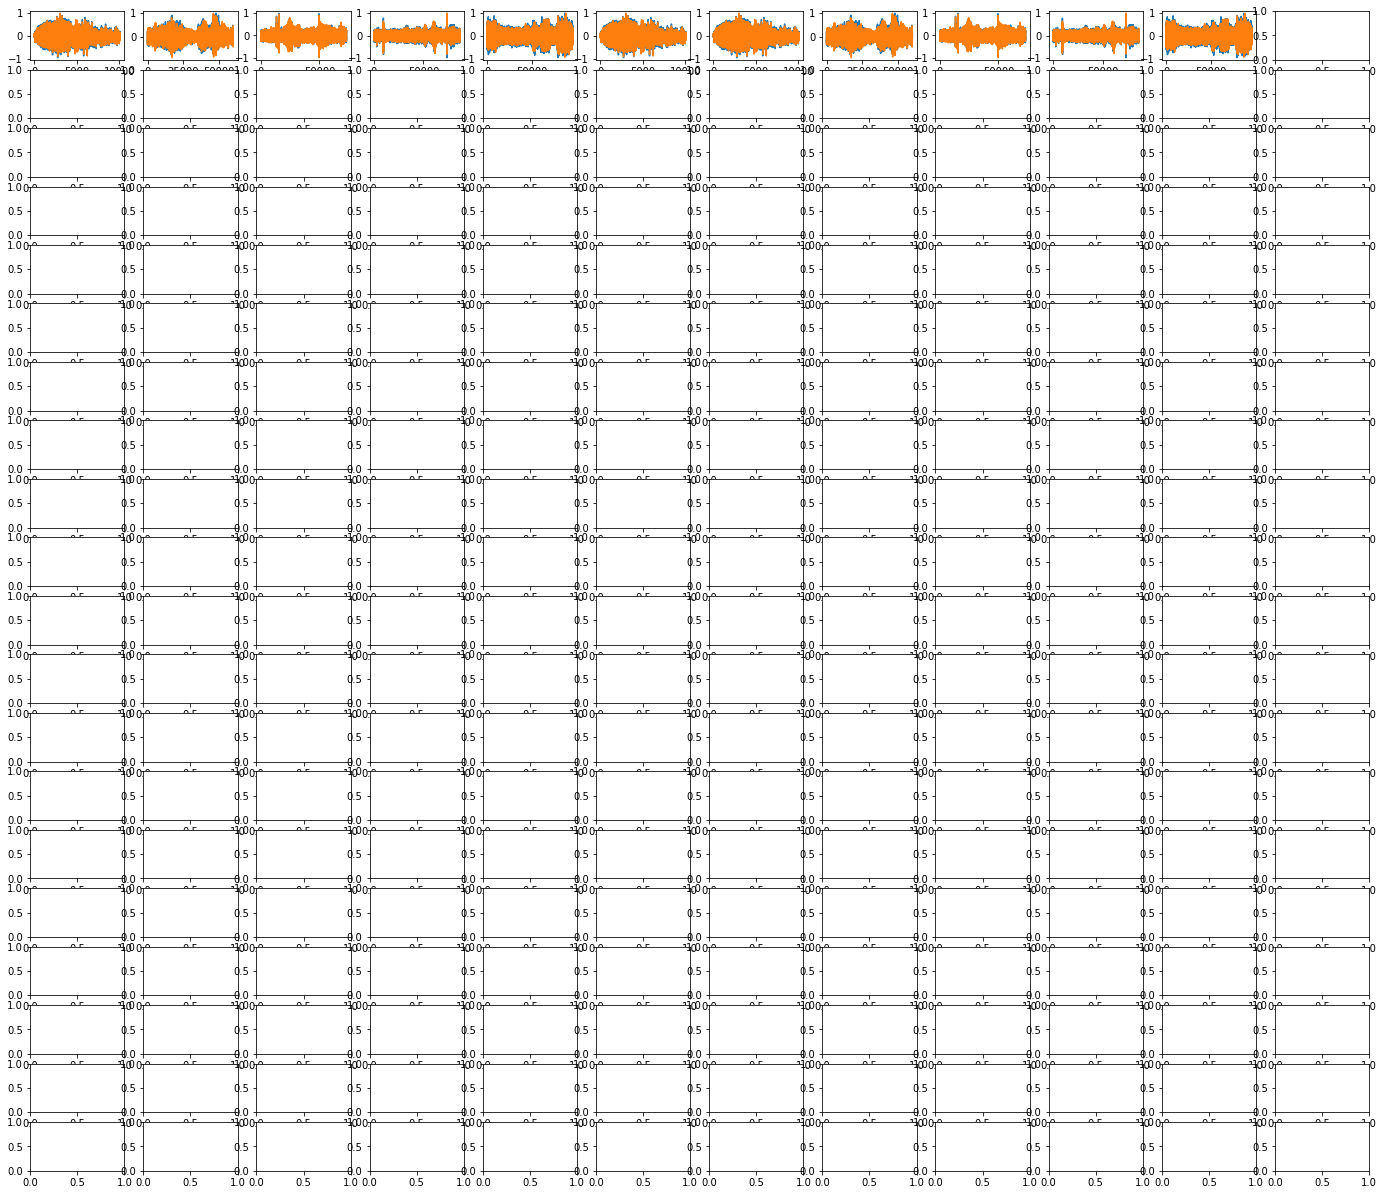

In [10]:
# plot some example audio 
nrows = 20
ncols = 12
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, turn in tqdm(enumerate(df_audio['audio'].values), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(turn)
    if i == nrows*ncols -1:
        break

### Save as `csv`

In [3]:
df_audio.to_csv("df_audio.csv", index=False)
df_audio

NameError: name 'df_audio' is not defined